# 3장 분류


In [1]:
from sklearn.datasets import fetch_openml

mnist =  fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
mnistDictKey=list(mnist.keys())

X, y = mnist[mnistDictKey[0]], mnist[mnistDictKey[1]]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


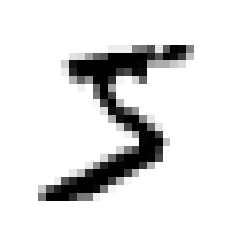

In [3]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

someDigit = X[0]
someDigitImage = someDigit.reshape(28, 28)
plt.imshow(someDigitImage, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [4]:
y = y.astype(np.uint8)#숫자형으로 변경

In [5]:
XTr, XTest, yTr,yTest = X[:60000],X[60000:],y[:60000],y[:60000]

In [6]:
yTr5 = (yTr==5)
yTest5 = (yTest==5)

In [7]:
yTr5

array([ True, False, False, ...,  True, False, False])

## 이진분류기

In [8]:
from sklearn.linear_model import SGDClassifier

sgdClf = SGDClassifier(random_state=42)
sgdClf.fit(XTr,yTr5)

SGDClassifier(random_state=42)

In [9]:
sgdClf.predict([someDigit])

array([ True])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone#데이터 복사 X 모델 복사

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for trainIndex, testIndex in skfolds.split(XTr, yTr5):
    cloneClf = clone(sgdClf)
    XTrFold = XTr[trainIndex]
    yTrFold = yTr5[trainIndex]
    XTestFold = XTr[testIndex]
    yTestFold = yTr5[testIndex]

    cloneClf.fit(XTrFold, yTrFold)
    yPred = cloneClf.predict(XTestFold)
    nCorrect = sum(yPred == yTestFold)
    print(nCorrect / len(yPred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5Clf=Never5Classifier()
cross_val_score(never5Clf,XTr,yTr5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

yTrPred = cross_val_predict(sgdClf, XTr, yTr5, cv=3)
confusion_matrix(yTr5, yTrPred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(yTr5, yTrPred))
print(recall_score(yTr5, yTrPred))

0.8370879772350012
0.6511713705958311


In [14]:
from sklearn.metrics import f1_score

f1_score(yTr5, yTrPred)

0.7325171197343846

In [15]:
yScores = sgdClf.decision_function([someDigit])
print(yScores)
threshold = 0
ySomeDigitPred = (yScores > threshold)
print(ySomeDigitPred)

[2164.22030239]
[ True]


In [16]:
threshold = 8000
ySomeDigitPred = (yScores > threshold)
ySomeDigitPred

array([False])

In [17]:
from sklearn.metrics import precision_recall_curve

yScores = cross_val_predict(sgdClf, XTr, yTr5, cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(yTr5, yScores)

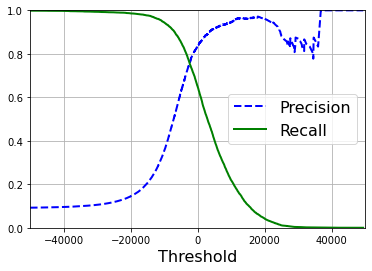

In [18]:
def plotting(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall90Prec = recalls[np.argmax(precisions >= 0.90)]
threshold90Prec = thresholds[np.argmax(precisions >= 0.90)]


# plt.figure(figsize=(8, 4))                                                                  # Not shown
plotting(precisions, recalls, thresholds)
# plt.plot([recall90Prec, threshold90Prec], [0., 0.9], "r:")                 # Not shown
# plt.plot([-50000, threshold90Prec], [0.9, 0.9], "r:")                                # Not shown
# plt.plot([-50000, threshold90Prec], [recall90Prec, recall90Prec], "r:")# Not shown
# plt.plot([threshold90Prec], [0.9], "ro")                                             # Not shown
# plt.plot([threshold90Prec], [recall90Prec], "ro")                             # Not shown
plt.show()

In [19]:
threshold90Prec = thresholds[np.argmax(precisions >= 0.90)]
yTr90Prec = (yScores >= threshold90Prec)

In [20]:
precision_score(yTr5, yTr90Prec)

0.9000345901072293

In [21]:
recall_score(yTr5, yTr90Prec)


0.4799852425751706

## ROC 곡선

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(yTr5, yScores)

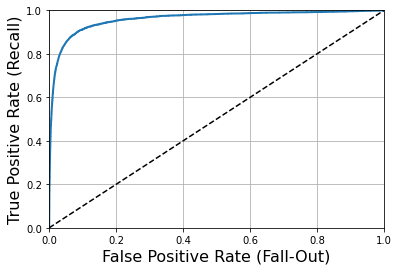

In [23]:
def plotRoc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

# plt.figure(figsize=(8, 6))                         # Not shown
plotRoc(fpr, tpr)
# plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
# plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
# plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(yTr5, yScores)

0.9604938554008616

In [25]:
from sklearn.ensemble import RandomForestClassifier

forestClf = RandomForestClassifier(n_estimators=100, random_state=42)
yProbasForest = cross_val_predict(forestClf, XTr, yTr5, cv=3,method="predict_proba")

In [26]:
yScoresForest = yProbasForest[:, 1] # 점수 = 양성 클래스의 확률
fprForest, tprForest, thresholdsForest = roc_curve(yTr5,yScoresForest)

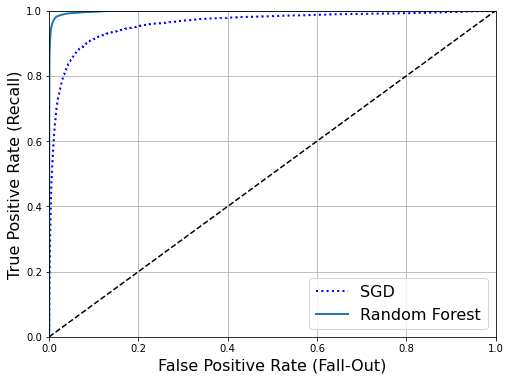

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plotRoc(fprForest, tprForest, "Random Forest")
# plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
# plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
# plt.plot([4.837e-3], [0.4368], "ro")
# plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
# plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [28]:
roc_auc_score(yTr5, yScoresForest)

0.9983436731328145

In [29]:
yTrPredForest = cross_val_predict(forestClf, XTr, yTr5, cv=3)
precision_score(yTr5, yTrPredForest)

0.9905083315756169

In [30]:
recall_score(yTr5, yTrPredForest)

0.8662608374838591

## 다중분류

In [31]:
from sklearn.svm import SVC

svmClf = SVC(random_state=42)
svmClf.fit(XTr[:1000], yTr[:1000]) # y_train_5이 아니라 y_train입니다
svmClf.predict([someDigit])

array([5], dtype=uint8)

In [32]:
someDigitScores = svmClf.decision_function([someDigit])
someDigitScores

array([[ 1.75828215,  2.74956232,  6.13809559,  8.2853702 , -0.28728967,
         9.30119996,  0.74228825,  3.79256174,  7.20847395,  4.85762716]])

In [33]:
np.argmax(someDigitScores)

5

In [34]:
svmClf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
svmClf.classes_[5]

5

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovrClf = OneVsRestClassifier(SVC(random_state=42))
ovrClf.fit(XTr[:1000], yTr[:1000])
ovrClf.predict([someDigit])

array([5], dtype=uint8)

In [39]:
len(ovrClf.estimators_)

10

In [40]:
sgdClf.fit(XTr, yTr)
sgdClf.predict([someDigit])

array([3], dtype=uint8)

In [41]:
sgdClf.decision_function([someDigit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
cross_val_score(sgdClf, XTr, yTr, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XTrScaled = scaler.fit_transform(XTr.astype(np.float64))
cross_val_score(sgdClf, XTrScaled, yTr, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [44]:
yTrPred = cross_val_predict(sgdClf, XTrScaled, yTr, cv=3)
confMx = confusion_matrix(yTr, yTrPred)
confMx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

NameError: name 'pt' is not defined

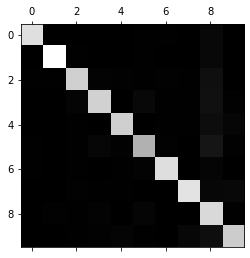

In [45]:
plt.matshow(confMx,cmap=plt.cm.gray)
pt.show

In [ ]:
rowSums = confMx.sum(axis=1, keepdims=True)
normConfMx = confMx / rowSums
np.fill_diagonal(normConfMx, 0)
plt.matshow(normConfMx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = XTr[(yTr == cl_a) & (yTrpred == cl_a)]
X_ab = XTr[(yTr == cl_a) & (yTrpred == cl_b)]
X_ba = XTr[(yTr == cl_b) & (yTrpred == cl_a)]
X_bb = XTr[(yTr == cl_b) & (yTrpred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

## 다중출력 분류